In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import numpy.matlib
import math 
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [4]:

all_train_data = pd.read_csv('/content/drive/My Drive/IS_HW1/mnist_train.csv') 
all_test_data = pd.read_csv('/content/drive/My Drive/IS_HW1/mnist_test.csv') 
train_label = all_train_data['label'].to_numpy()

test_label = all_test_data['label'].to_numpy()
train_data = all_train_data.to_numpy()[:,0:-1]
test_data = all_test_data.to_numpy()[:,0:-1]

In [5]:
def k_fold(data, k,seed,label):
  if label ==0:
    h, w = data.shape
    reminder = h%k
    arr = data.copy() [:h-reminder,:]
    nrows = int(np.floor(h/k))
    train_temp = np.zeros((nrows*(k-1),w))
    test_temp = np.zeros((nrows,w))
    test_temp = arr[seed*nrows:(seed+1)*nrows,:]
    train_temp = np.delete(arr, np.s_[seed*nrows:(seed+1)*nrows], 0)
  else:
    h = data.shape [0]
    reminder = h%k
    arr = data.copy() [:h-reminder]
    nrows = int(np.floor(h/k))
    train_temp = np.zeros((nrows*(k-1)))
    test_temp = np.zeros((nrows))
    test_temp = arr[seed*nrows:(seed+1)*nrows]
    train_temp = np.delete(arr, np.s_[seed*nrows:(seed+1)*nrows], 0)
  return test_temp,train_temp


In [6]:
def cal_acc(b, w, test, label_test,one_class):
  y_hat_test = np.zeros((test.shape [0],1))
  for test_datan in range(label_test.shape [0]):
    ri = np.arange(w.shape [0])
    np.random.shuffle(ri)
    if one_class == 1:
      
      if np.dot(w, test[test_datan,:]) -b>=label_test[test_datan]:
        y_hat_test[test_datan,0] = 1
      else:
        y_hat_test[test_datan,0] = -1
    else:
      for class_test in range(w.shape [0]):
        if np.dot(w[ri[class_test],:], test[test_datan,:]) -b[ri[class_test],:]>=label_test[test_datan]:
          y_hat_test[test_datan,0] = ri[class_test]
        else:
          y_hat_test[test_datan,0] = -1
  epoch_acc = np.sum(y_hat_test[:,0] == label_test[:])/(label_test.shape [0])
  return epoch_acc*100
  

In [7]:
def SGD(w, b, train, label, learning_rate, lambd,test, label_test):
  y_hat = np.zeros((train.shape [0], 1))
  random_index = np.arange(train.shape [0])
  np.random.shuffle(random_index)
  
  for data_num in range(train.shape [0]):
    condition =(1 - label[random_index[data_num]]*(np.dot(w, train[random_index[data_num],:]) - b))
    if condition>0:
      w = 2*lambd*w - learning_rate*label[random_index[data_num]]*train[random_index[data_num],:]
      b = label[random_index[data_num]]
    else:
      w = 2*lambd*w
      b=0
  temp = np.dot(w, test[1,:]) -b
  
  return w, b
      

In [8]:
def BGD(w, b, train, label, learning_rate, lambd,test, label_test,batch):
  y_hat = np.zeros((train.shape [0], 1))
  k =(train.shape [0])/batch
  random_index = np.arange(k)
  np.random.shuffle(random_index)
  for data_num in range(int(k)):
    temp_data = train[int(batch*random_index[data_num]):int(batch*random_index[data_num]+batch),:]
    temp_label = label[int(batch*random_index[data_num]):int(batch*random_index[data_num]+batch)]
    for i in range(10):
        condition =(1 - temp_label[i]*(np.dot(w, temp_data[i,:]) - b))
        if condition>0:
            w = 2*lambd*w - learning_rate*temp_label[i]*temp_data[i,:]
            b = temp_label[i]/batch
        else:
            w = 2*lambd*w
            b=0
  return w, b

In [9]:
def loss_function(w, b, data_train, label_train, lambd):
  first_term = lambd*(LA.norm(w))
  second_term =0
  for i in range(data_train.shape [0]):
    temp = max(0, 1 - label_train[i]*(np.dot(w,data_train[i]) - b))/(label_train.shape [0])
    second_term = second_term + temp
  return first_term + second_term

In [10]:
def normalize_label(target_label, all_labels):
  normalized_labels = np.zeros((all_labels.shape [0], 1))
  for i in range(all_labels.shape [0]):
    if target_label == all_labels[i]:
      normalized_labels[i] = 1
      normalized_labels[i] = int(normalized_labels[i])
    else:
      normalized_labels[i]=-1
      normalized_labels[i] = int(normalized_labels[i])
  return normalized_labels


In [11]:
def SVM_SGD(train, label_train, test, label_test, learning_rate, lambd, decreasing_mode, epoch):
  data_class = np.array(range(10))
  epoch_acc = np.zeros((1,epoch))
  epoch_loss = np.zeros(epoch)
  b_temp = np.zeros((10,1, epoch))
  w_temp = np.zeros((10, 28*28, epoch))
  loss_tmp = normalize_label(1,label_train)
  for dc in range(10):
    train_normal_labels = normalize_label(data_class[dc],label_train)
    test_normal_labels = normalize_label(data_class[dc],label_test)
    for epoch_num in range(epoch):
        if decreasing_mode == 1:
            learning_rate = learning_rate/(np.floor(epoch_num/7)+1)
        if epoch_num == 0 :
            b_temp[dc,:,epoch_num] = 0
            w_temp[dc,:,epoch_num] = 0.01*np.random.randn(1, 28*28)
            w_temp[dc ,: ,epoch_num],   b_temp[dc,:,epoch_num]  = SGD(w_temp[dc, :, epoch_num], b_temp[dc, :, epoch_num], train, train_normal_labels, learning_rate, lambd,test, test_normal_labels)
        else:
            w_temp[dc, :, epoch_num],   b_temp[dc,:, epoch_num] = SGD(w_temp[dc, :, epoch_num], b_temp[dc, :, epoch_num], train, train_normal_labels, learning_rate, lambd,test, test_normal_labels)

  return w_temp, b_temp




In [12]:
def SVM_BGD(train, label_train, test, label_test, learning_rate, lambd, decreasing_mode, epoch,batch):
  data_class = np.array(range(10))
  epoch_acc = np.zeros((1,epoch))
  epoch_loss = np.zeros(epoch)
  b_temp = np.zeros((10,1, epoch))
  w_temp = np.zeros((10, 28*28, epoch))
  loss_tmp = normalize_label(1,label_train)
  for dc in range(10):
    train_normal_labels = normalize_label(data_class[dc],label_train)
    test_normal_labels = normalize_label(data_class[dc],label_test)
    for epoch_num in range(epoch):
        if decreasing_mode == 1:
            learning_rate = learning_rate/(np.floor(epoch_num/7)+1)
        if epoch_num == 0 :
            b_temp[dc,:,epoch_num] = 0
            w_temp[dc,:,epoch_num] = 0.01*np.random.randn(1, 28*28)
            w_temp[dc ,: ,epoch_num],   b_temp[dc,:,epoch_num]  = BGD(w_temp[dc, :, epoch_num], b_temp[dc, :, epoch_num], train, train_normal_labels, learning_rate, lambd,test, test_normal_labels,batch)
        else:
            w_temp[dc, :, epoch_num],   b_temp[dc,:, epoch_num] = BGD(w_temp[dc, :, epoch_num], b_temp[dc, :, epoch_num], train, train_normal_labels, learning_rate, lambd,test, test_normal_labels,batch)

  return w_temp, b_temp

In [13]:
def optimal_lamda(target_class,train, label_train, test, label_test, learning_rate, lambd, epoch):
  b_temp = np.zeros(1)
  w_temp = np.zeros(28*28)
  loss_epoch = np.zeros(lambd.shape [0])
  acc = np.zeros(lambd.shape [0])
  train_normal_labels = normalize_label(target_class,label_train)
  test_normal_labels = normalize_label(target_class,label_test)
  for lmbda in range(lambd.shape [0]):
    lambdaa = lambd[lmbda]
    for epoch_num in range(epoch):
        if epoch_num == 0 :
            b_temp[:] = 0
            w_temp[:] = 0.01*np.random.randn(1, 28*28)
            w_temp[:], b_temp[:] = SGD(w_temp[:], b_temp[:], train, train_normal_labels, learning_rate, lambdaa,test, test_normal_labels)
        else:
            w_temp[:], b_temp[:] = SGD(w_temp[:], b_temp[:], train, train_normal_labels, learning_rate, lambdaa,test, test_normal_labels)
    loss_epoch[lmbda] = loss_function(w_temp, b_temp, train, train_normal_labels, lambdaa )
    acc[lmbda],tmp = cal_acc(b_temp, w_temp, test, test_normal_labels,1)
  return acc, loss_epoch

**Question 3 - part 1,2**

In [64]:
lamdas = np.array([1,10**-2,10**-4,10**-6,10**-8,10**-10])
acc_lambda = np.zeros((5,6))
loss_lambda = np.zeros((5,6))
for fold in range(5):
   test_temp_data, train_temp_data = k_fold(train_data, 5, fold,0)
   test_temp_label, train_temp_label = k_fold(train_label, 5, fold,1)
   acc_lambda[fold,:], loss_lambda[fold] =optimal_lamda(5,train_temp_data,  train_temp_label, test_temp_data, test_temp_label, 0.1, lamdas, 20)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in multiply
  if sys.path[0] == '':


In [65]:
a=np.mean(acc_lambda,axis=0)


In [68]:
i=0
for acc in a:
  temp = 'accuracy of 5-fold cross validation for lmbda= 1e' +str(-i)+' is : {} %'
  i+=2
  print( temp.format(acc))

accuracy of 5-fold cross validation for lmbda= 1e0 is : 90.965 %
accuracy of 5-fold cross validation for lmbda= 1e-2 is : 9.035 %
accuracy of 5-fold cross validation for lmbda= 1e-4 is : 9.035 %
accuracy of 5-fold cross validation for lmbda= 1e-6 is : 9.035 %
accuracy of 5-fold cross validation for lmbda= 1e-8 is : 9.035 %
accuracy of 5-fold cross validation for lmbda= 1e-10 is : 9.035 %


**Part 3**

In [75]:
w_temp,b_temp = SVM_SGD(train_data, train_label, test_data, test_label, 1, 10**-2, 0, 80);

In [92]:
not_decreasing_SGD_acc =np.zeros(80)
not_decreasing_SGD_loss= np.zeros(80)
epoch_acc = np.zeros(80)
epoch_loss = np.zeros(80)
for en in range(80):
    epoch_acc[ en] =  cal_acc(b_temp[:, :, en], w_temp[:, :, en], test_data, test_label,0)
    for dc in range(10):
      epoch_loss[en] += loss_function(w_temp[dc,:,en],b_temp[dc,:,en],train_data,normalize_label(dc,train_label), 10**-2)/10

Text(0, 0.5, 'epoch')

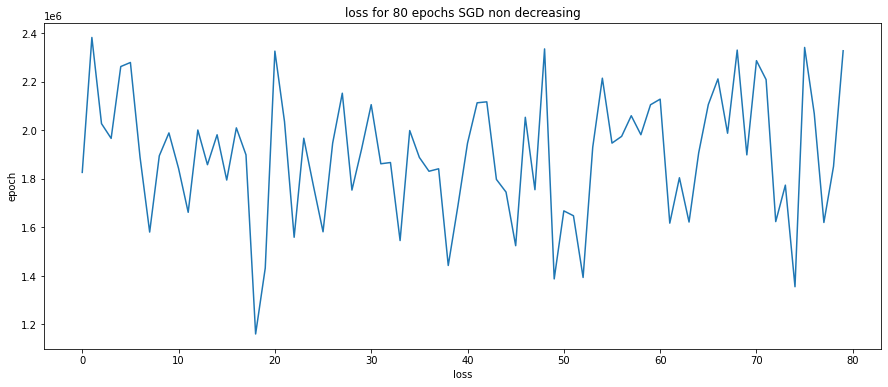

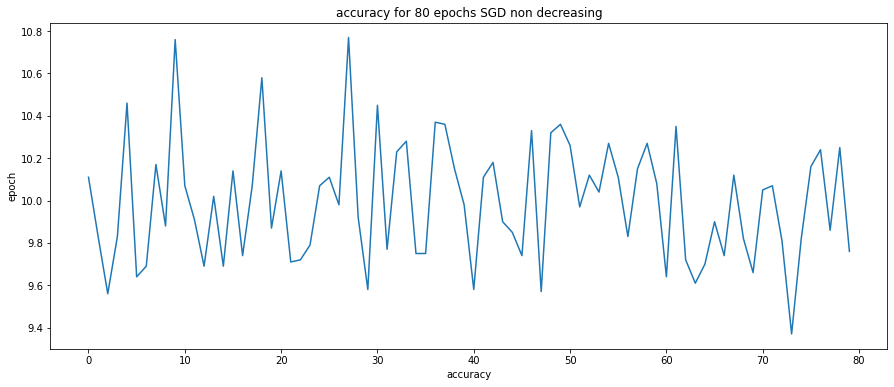

In [98]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.plot(epoch_loss)
plt.title('loss for 80 epochs SGD non decreasing')
plt.xlabel('loss')
plt.ylabel('epoch')
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.plot(epoch_acc)
plt.title('accuracy for 80 epochs SGD non decreasing')
plt.xlabel('accuracy')
plt.ylabel('epoch')

In [14]:
w_temp_bgd,b_temp_bgd = SVM_BGD(train_data, train_label, test_data, test_label, 1, 0.01, 0, 20,10)

In [15]:
not_decreasing_BGD_acc =np.zeros(20)
not_decreasing_BGD_loss= np.zeros(20)
epoch_acc = np.zeros(20)
epoch_loss = np.zeros(20)
for en in range(20):
    epoch_acc[ en] =  cal_acc(b_temp_bgd[:, :, en], w_temp_bgd[:, :, en], test_data, test_label,0)
    for dc in range(10):
      epoch_loss[en] += loss_function(w_temp_bgd[dc,:,en],b_temp_bgd[dc,:,en],train_data,normalize_label(dc,train_label), 1)/10

Text(0, 0.5, 'epoch')

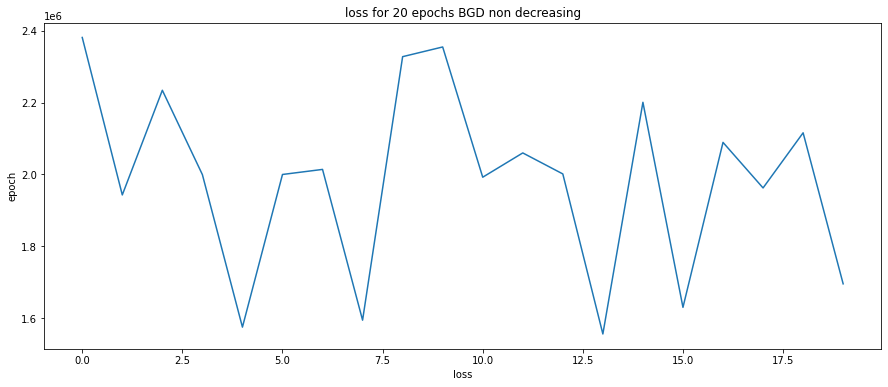

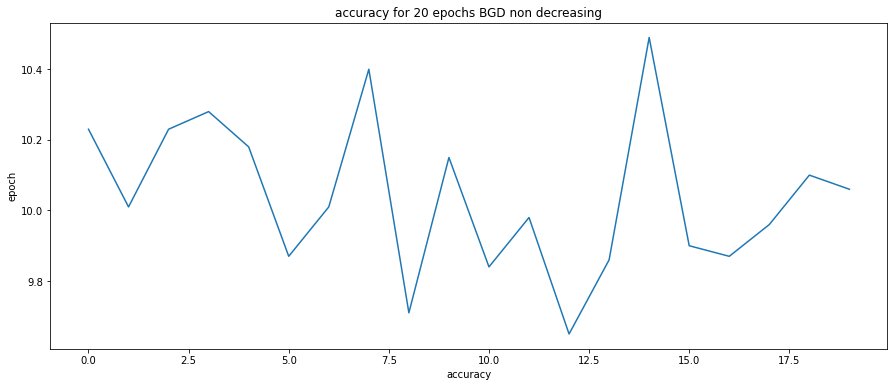

In [16]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.plot(epoch_loss)
plt.title('loss for 20 epochs BGD non decreasing')
plt.xlabel('loss')
plt.ylabel('epoch')
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.plot(epoch_acc)
plt.title('accuracy for 20 epochs BGD non decreasing')
plt.xlabel('accuracy')
plt.ylabel('epoch')

**Decreasing mode**

In [17]:
w_temp_d,b_temp_d = SVM_SGD(train_data, train_label, test_data, test_label, 1, 0.01, 1, 20);

In [18]:
decreasing_SGD_acc =np.zeros(20)
decreasing_SGD_loss= np.zeros(20)
epoch_acc = np.zeros(20)
epoch_loss = np.zeros(20)
for en in range(20):
    epoch_acc[ en] =  cal_acc(b_temp_d[:, :, en], w_temp_d[:, :, en], test_data, test_label,0)
    for dc in range(10):
      epoch_loss[en] += loss_function(w_temp_d[dc,:,en],b_temp_d[dc,:,en],train_data,normalize_label(dc,train_label), 10**-2)/10

Text(0, 0.5, 'epoch')

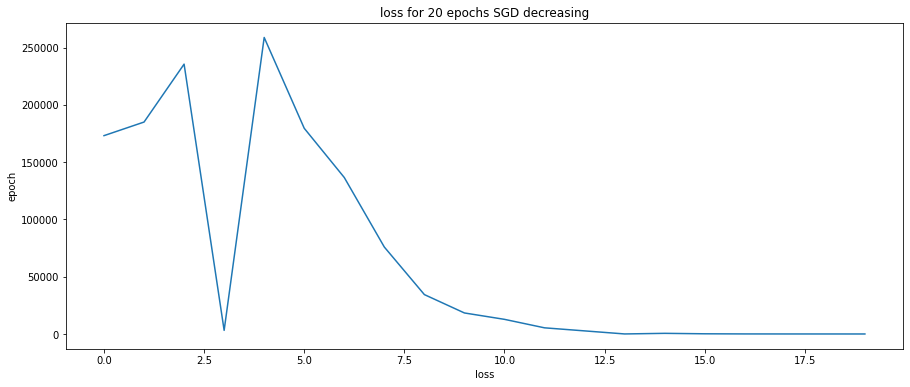

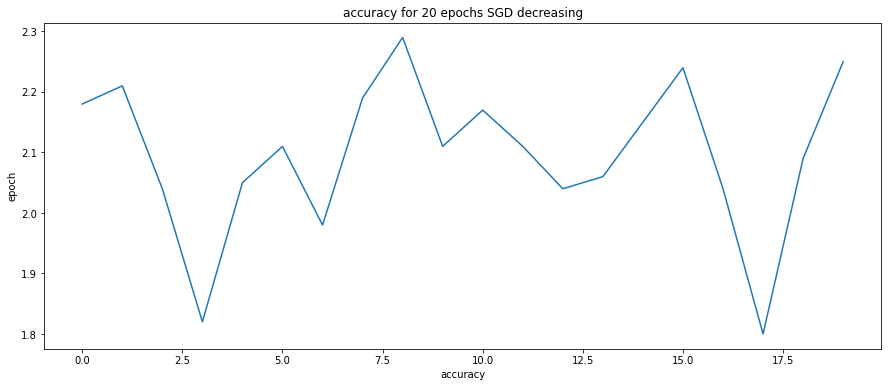

In [19]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.plot(epoch_loss)
plt.title('loss for 20 epochs SGD decreasing')
plt.xlabel('loss')
plt.ylabel('epoch')
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.plot(epoch_acc)
plt.title('accuracy for 20 epochs SGD decreasing')
plt.xlabel('accuracy')
plt.ylabel('epoch')

In [20]:
w_temp_d,b_temp_d = SVM_BGD(train_data, train_label, test_data, test_label, 1, 0.01, 1, 20,10);

In [22]:
decreasing_BGD_acc =np.zeros(20)
decreasing_BGD_loss= np.zeros(20)
epoch_acc = np.zeros(20)
epoch_loss = np.zeros(20)
for en in range(20):
    epoch_acc[ en] =  cal_acc(b_temp_d[:, :, en], w_temp_d[:, :, en], test_data, test_label,0)
    for dc in range(10):
      epoch_loss[en] += loss_function(w_temp_d[dc,:,en],b_temp_d[dc,:,en],train_data,normalize_label(dc,train_label), 10**-2)/10
      

Text(0, 0.5, 'epoch')

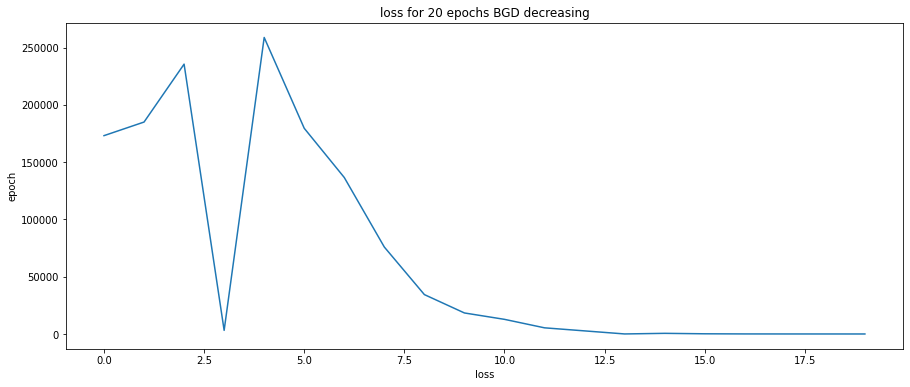

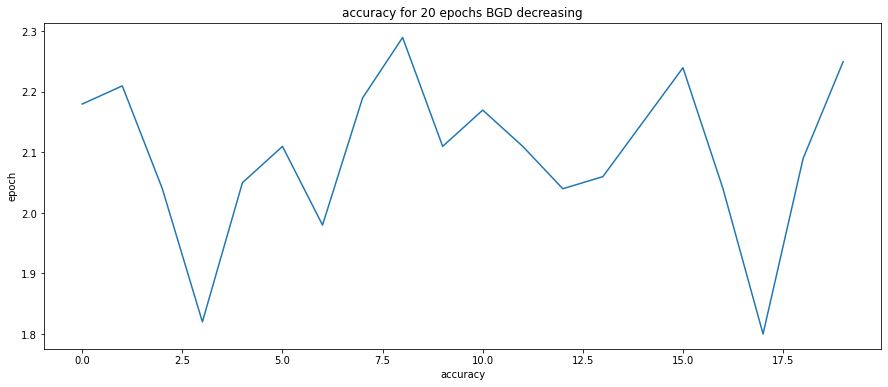

In [21]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.plot(epoch_loss)
plt.title('loss for 20 epochs BGD decreasing')
plt.xlabel('loss')
plt.ylabel('epoch')
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.plot(epoch_acc)
plt.title('accuracy for 20 epochs BGD decreasing')
plt.xlabel('accuracy')
plt.ylabel('epoch')